# Adler project

Work on EAGLE lens models: comparison to true maps, inertia tensor, arrival time grids, ...


### Imports
`gleam` imports must happen from root of the directory, i.e. `/Users/phdenzel/adler/`.
This is why `..` is appended to the path.


In [ ]:
import sys
sys.path.append('..')
import os
import re
import numpy as np
from scipy import interpolate
from astropy.io import fits
import matplotlib.pyplot as plt

from gleam.multilens import MultiLens
from gleam.reconsrc import ReconSrc
from gleam.glass_interface import glass_renv, filter_env, export_state
glass = glass_renv()

%load_ext skip_kernel_extension


### Reading data
Reading in all relevant files as dictionaries with ids as keys and list of filenames as values


In [ ]:
rdir = "/Users/phdenzel/adler"
jsondir = rdir+"/json/"
statedir = rdir+"/states/v2/"
kappadir = rdir+"/kappa/"
keys = ["H1S0A0B90G0", "H1S1A0B90G0", "H2S1A0B90G0", "H2S2A0B90G0", "H2S7A0B90G0",
        "H3S0A0B90G0", "H3S1A0B90G0", "H4S3A0B0G90", "H10S0A0B90G0", "H13S0A0B90G0",
        "H23S0A0B90G0", "H30S0A0B90G0", "H36S0A0B90G0", "H160S0A90B0G0",
        "H234S0A0B90G0"]


In [ ]:
def an_sorted(data):
    """
    Perform an alpha-numeric, natural sort

    Args:
        data <list> - list of strings

    Kwargs:
        None

    Return:
        sorted <list> - the alpha-numerically, naturally sorted list of strings
    """
    def convert(text):
        return int(text) if text.isdigit() else text.lower()

    def an_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=an_key)


ls_jsons = an_sorted([os.path.join(jsondir, f) for f in os.listdir(jsondir)
                      if f.endswith('.json')])
ls_states = an_sorted([os.path.join(statedir, f) for f in os.listdir(statedir)
                       if f.endswith('.state')])
ls_kappas = an_sorted([os.path.join(kappadir, f) for f in os.listdir(kappadir)
                       if f.endswith('.kappa.fits')])


In [ ]:
jsons = {k: [f for f in ls_jsons if k in f] for k in keys}
filtered_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_filtered.state')] for k in keys}
ls_states = [f for f in ls_states if not f.endswith('_filtered.state')]

prefiltered_fsynth10_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf10.state')] for k in keys}
prefiltered_fsynth25_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf25.state')] for k in keys}
prefiltered_fsynth50_states = {k: [f for f in ls_states
                                   if k in f and f.endswith('_filtered_synthf50.state')] for k in keys}
ls_states = [f for f in ls_states if not (f.endswith('_filtered_synthf10.state')
                                          or f.endswith('_filtered_synthf10.state')
                                          or f.endswith('_filtered_synthf10.state'))]

synthf10_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf10.state')] for k in keys}
synthf25_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf25.state')] for k in keys}
synthf50_states = {k: [f for f in ls_states
                       if k in f and f.endswith('_synthf50.state')] for k in keys}
ls_states = [f for f in ls_states if not (f.endswith('_synthf10.state')
                                          or f.endswith('_synthf25.state')
                                          or f.endswith('_synthf50.state'))]

states = {k: [f for f in ls_states if k in f] for k in keys}

kappa_map_files = {k: [f for f in ls_kappas if k in f] for k in keys}


## Comparison to true EAGLE models

#### Reading the files

In [ ]:
# EAGLE models
filepath = kappa_map_files["H3S0A0B90G0"][0]
# filepath = kappa_map_files["H10S0A0B90G0"][0]
# filepath = kappa_map_files["H36S0A0B90G0"][0]
eagle_kappa_map, eagle_hdrobj = fits.getdata(filepath, header=True)

# GLASS models
#statefile = states["H3S0A0B90G0"][0]
statefile = prefiltered_fsynth50_states["H3S0A0B90G0"][0]  # prefiltered_fsynth50_states["H3S0A0B90G0"][0]
# statefile = prefiltered_fsynth50_states["H10S0A0B90G0"][0]
# statefile = prefiltered_fsynth50_states["H36S0A0B90G0"][0]
glass_state = glass.glcmds.loadstate(statefile)
glass_state.make_ensemble_average()

kkwargs = dict(vmin=0, vmax=eagle_kappa_map.max())


#### The true EAGLE models

In [ ]:
eagle_pixrad = tuple(r//2 for r in eagle_kappa_map.shape)
eagle_maprad = eagle_pixrad[1]*eagle_hdrobj['CDELT2']*3600
eagle_mapextent = ((eagle_pixrad[0]+0.5)*eagle_hdrobj['CDELT1']*3600,
                  (eagle_pixrad[1]+0.5)*eagle_hdrobj['CDELT2']*3600)
eagle_cell_size = -3600*eagle_hdrobj['CDELT1']
assert(eagle_hdrobj['CUNIT1' == 'deg'])

print("Kappa map: {}".format(eagle_kappa_map.shape))
print("Pixrad {}".format(eagle_pixrad))
print("Maprad {}".format(eagle_maprad))
print("Mapextent {}".format(eagle_mapextent))
print("Cellsize {}".format(eagle_cell_size))


In [ ]:
plt.imshow(np.log10(eagle_kappa_map))
plt.colorbar()
plt.gca().axis('off')
plt.show()


#### Resample EAGLE model to match GLASS model

In [ ]:
def resample_eaglemodel(eagle_model, extent, shape, verbose=False):
    """
    Resample (usually downsample) an EAGLE model's kappa grid to match the specified scales and dimensions

    Args:
        eagle_model <tuple(np.ndarray, header object)> - EAGLE model with (data, hdr)
        extent <tuple/list> - extent of the output
        shape <tuple/list> - shape of the output

    Kwargs:
        verbose <bool> - verbose mode; print command line statements

    Return:
        kappa_resmap <np.ndarray> - resampled kappa grid
    """
    kappa_map = eagle_model[0]
    hdr = eagle_model[1]

    pixrad = tuple(r//2 for r in kappa_map.shape)
    maprad = pixrad[1]*hdr['CDELT2']*3600

    xmdl = np.linspace(-maprad, maprad, kappa_map.shape[0])
    ymdl = np.linspace(-maprad, maprad, kappa_map.shape[1])
    newx = np.linspace(extent[0], extent[1], shape[0])
    newy = np.linspace(extent[2], extent[3], shape[1])

    rescale = interpolate.interp2d(xmdl, ymdl, kappa_map)
    kappa_resmap = rescale(newx, newy)
    kappa_resmap[kappa_resmap < 0] = 0

    return kappa_resmap

In [ ]:
glass_objdta = glass_state.models[0]['obj,data'][0]
glsmdl_maprad = glass_objdta[0].basis.top_level_cell_size * (glass_objdta[0].basis.pixrad)
shape = glass_objdta[0].basis._to_grid(glass_objdta[1]['kappa'], 1).shape
extent = (-glsmdl_maprad, glsmdl_maprad, -glsmdl_maprad, glsmdl_maprad)
eagle_kappa_resmap = resample_eaglemodel(fits.getdata(filepath, header=True), extent, shape)

plt.imshow(np.log10(eagle_kappa_resmap))
plt.colorbar()
plt.gca().axis('off')
plt.show()


#### Residuals (EAGLE2GLASS)

In [ ]:
%%skip True

glass_objdta = glass_state.models[0]['obj,data'][0]
glass_kappa_map = glass_objdta[0].basis._to_grid(glass_objdta[1]['kappa'], 1)

resid_map = eagle_kappa_resmap - glass_kappa_map
resid2_map = resid_map * resid_map
r = np.sum(resid2_map)
print(r)


In [ ]:
%%skip True

plt.imshow(resid_map)
plt.colorbar()
plt.gca().axis('off')
plt.show()


#### Comparison loop for a single model (EAGLE2GLASS)

In [ ]:
N_models = len(glass_state.models)
print("{} models".format(N_models))

kappa_resids = []
eagle_model = fits.getdata(filepath, header=True)
for m in glass_state.models:
    objdta = m['obj,data'][0]
    glass_kappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)
    maprad = objdta[0].basis.top_level_cell_size * (objdta[0].basis.pixrad)
    shape = glass_kappa_map.shape
    extent = (-maprad, maprad, -maprad, maprad)

    kappa_resmap = resample_eaglemodel(eagle_model, extent, shape)

    # residuals
    resid_map = kappa_resmap - glass_kappa_map
    resid2_map = resid_map * resid_map
    r = np.sum(resid2_map)
    kappa_resids.append(r)

minidx = np.argmin(kappa_resids)
print("Best fitting model index: {}".format(minidx))
print("with residual {}".format(kappa_resids[minidx]))
print(kappa_resids[minidx-4:minidx+4])


In [ ]:
objdta = glass_state.models[minidx]['obj,data'][0]
min_e2gkappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)
maprad = objdta[0].basis.top_level_cell_size * (objdta[0].basis.pixrad)
shape = min_e2gkappa_map.shape
extent = (-maprad, maprad, -maprad, maprad)

kappa_resmap = resample_eaglemodel(eagle_model, extent, shape)

resid_map = kappa_resmap - min_e2gkappa_map
resid2_map = resid_map * resid_map

plt.imshow(min_e2gkappa_map, extent=extent)
plt.colorbar()
# plt.gca().axis('off')
plt.show()

plt.imshow(resid_map)
plt.colorbar()
plt.gca().axis('off')
plt.show()

#### The GLASS models

In [ ]:
glass_model = glass_state.models[0]
glassobj, glassdta = glass_model['obj,data'][0]
glass_kappa_map = glassobj.basis._to_grid(glassdta['kappa'], 1)

glass_pixrad = glassobj.basis.pixrad
glass_maprad = glassobj.basis.top_level_cell_size * (glassobj.basis.pixrad)
glass_mapextent = (-glassobj.basis.top_level_cell_size * (glassobj.basis.pixrad+0.5),
                 glassobj.basis.top_level_cell_size * (glassobj.basis.pixrad+0.5))
glass_cell_size = glassobj.basis.top_level_cell_size

print("Kappa map: {}".format(glass_kappa_map.shape))
print("Pixrad {}".format(glass_pixrad))
print("Maprad {}".format(glass_maprad))
print("Mapextent {}".format(glass_mapextent))
print("Cellsize {}".format(glass_cell_size))


In [ ]:
# kkwargs = dict()
plt.imshow(glass_kappa_map, **kkwargs)
plt.colorbar()
plt.gca().axis('off')
plt.show()


In [ ]:
%%skip True
glass_state.img_plot(obj_index=0, color='#fe4365')
glass_state.arrival_plot(glass_state.ensemble_average, obj_index=0, only_contours=True,
                         clevels=75, colors=['#603dd0'])
glass_state.arrival_plot(glass_state.ensemble_average, obj_index=1, only_contours=True,
                         clevels=50, colors=['#da9605'])
plt.show()

#### Resample GLASS model to match EAGLE model

In [ ]:
def resample_glassmodel(gls_model, extent, shape, verbose=False):
    """
    Resample (usually upsample) a GLASS model's kappa grid to match the specified scales and dimensions

    Args:
        gls_model <glass.LensModel object> - GLASS ensemble model
        extent <tuple/list> - extent of the output
        shape <tuple/list> - shape of the output

    Kwargs:
        verbose <bool> - verbose mode; print command line statements

    Return:
        kappa_resmap <np.ndarray> - resampled kappa grid
    """
    obj, data = gls_model['obj,data'][0]
    kappa_map = obj.basis._to_grid(data['kappa'], 1)
    pixrad = obj.basis.pixrad
    maprad = obj.basis.top_level_cell_size * (obj.basis.pixrad)
    mapextent = (-obj.basis.top_level_cell_size * (obj.basis.pixrad+0.5),
                 obj.basis.top_level_cell_size * (obj.basis.pixrad+0.5))
    cell_size = obj.basis.top_level_cell_size

    if verbose:
        print(obj)
        print("Kappa map: {}".format(kappa_map.shape))
        print("Pixrad {}".format(pixrad))
        print("Maprad {}".format(maprad))
        print("Mapextent {}".format(mapextent))
        print("Cellsize {}".format(cell_size))

    xmdl = np.linspace(-maprad, maprad, kappa_map.shape[0])
    ymdl = np.linspace(-maprad, maprad, kappa_map.shape[1])
    Xmdl, Ymdl = np.meshgrid(xmdl, ymdl)
    xnew = np.linspace(extent[0], extent[1], shape[0])
    ynew = np.linspace(extent[2], extent[3], shape[1])
    Xnew, Ynew = np.meshgrid(xnew, ynew)

    rescale = interpolate.Rbf(Xmdl, Ymdl, kappa_map)
    kappa_resmap = rescale(Xnew, Ynew)
    kappa_resmap[kappa_resmap < 0] = 0

    return kappa_resmap


In [ ]:
eagle_pixrad = tuple(r//2 for r in eagle_kappa_map.shape)
eagle_maprad = eagle_pixrad[1]*eagle_hdrobj['CDELT2']*3600
shape = eagle_kappa_map.shape
extent = [-eagle_maprad, eagle_maprad, -eagle_maprad, eagle_maprad]
glass_kappa_resmap = resample_glassmodel(glass_state.models[0], extent, shape)


In [ ]:
%%skip True

x = np.linspace(-mdl_maprad, mdl_maprad, mdl_kappa_map.shape[0])
y = np.linspace(-mdl_maprad, mdl_maprad, mdl_kappa_map.shape[1])
newx = np.linspace(-eagle_maprad, eagle_maprad, eagle_kappa_map.shape[0])
newy = np.linspace(-eagle_maprad, eagle_maprad, eagle_kappa_map.shape[1])

rescale = interpolate.interp2d(x, y, mdl_kappa_map, kind='linear')
# rescale = interpolate.RectBivariateSpline(x, y, mdl_kappa_map)
glass_kappa_resmap = rescale(newx, newy)


In [ ]:
plt.imshow(glass_kappa_resmap, **kkwargs)
plt.colorbar()
plt.gca().axis('off')
plt.show()


#### Residuals (GLASS2EAGLE)

In [ ]:
%%skip True

resid_map = eagle_kappa_map - glass_kappa_resmap
resid2_map = resid_map * resid_map
r = np.sum(resid2_map)
print(r)


In [ ]:
%%skip True

plt.imshow(resid_map)
plt.colorbar()
plt.gca().axis('off')
plt.show()


#### Comparison loop for a single model (GLASS2EAGLE)

In [ ]:
N_models = len(glass_state.models)
print("{} models".format(N_models))

kappa_resids = []
extent = [-eagle_maprad, eagle_maprad, -eagle_maprad, eagle_maprad]
for m in glass_state.models:
    mdl_kappa_resmap = resample_glassmodel(m, extent, eagle_kappa_map.shape)

    # residuals
    resid_map = eagle_kappa_map - mdl_kappa_resmap
    resid2_map = resid_map * resid_map
    r = np.sum(resid2_map)
    kappa_resids.append(r)

minidx2 = np.argmin(kappa_resids)
print("Best fitting model index: {}".format(minidx2))
print("with residual {}".format(kappa_resids[minidx2]))
print(kappa_resids[minidx2-4:minidx2+4])


In [ ]:
min_g2ekappa_map = resample_glassmodel(glass_state.models[minidx2], extent, eagle_kappa_map.shape)
resid_map = eagle_kappa_map - min_g2ekappa_map
resid2_map = np.sqrt(resid_map * resid_map)

plt.imshow(min_g2ekappa_map, **kkwargs)
plt.colorbar()
plt.gca().axis('off')
plt.show()

plt.imshow(resid_map)
plt.colorbar()
plt.gca().axis('off')
plt.show()


## Check COM

The center of mass is defined as

\begin{equation}
\mathbf{R} = \frac{1}{M} \sum_{i=1}^{n}m_{i}\mathbf{r}_{i}
\end{equation}


In [131]:
def center_of_mass(kappa_map, pixel_scale=1, center=False):
    """
    Calculate the 2D position of the center of mass

    Args:
        kappa_map <np.ndarray> - a 2D grid of kappa tiles

    Kwargs:
        pixel_scale <float> - the pixel scale
        center <bool> - return the COM relative to the map center

    Return:
        com <np.ndarray> - center of mass on the kappa coordinate grid as (x, y)
    """
    invM = 1./np.sum(kappa_map)
    x1 = np.linspace(-(kappa_map.shape[0]//2), kappa_map.shape[0]//2,
                     kappa_map.shape[0]) * pixel_scale
    y1 = np.linspace(-(kappa_map.shape[1]//2), kappa_map.shape[1]//2,
                     kappa_map.shape[1]) * pixel_scale
    x, y = np.meshgrid(x1, y1)
    rk = np.array([x*kappa_map, y*kappa_map])
    com = np.sum(invM*rk, axis=(2, 1))
    if not center:
        com += pixel_scale * (np.array(kappa_map.shape) // 2)
    return com

eagle_com = center_of_mass(eagle_kappa_map)
eagle_res_com = center_of_mass(eagle_kappa_resmap)
glassg2e_com = center_of_mass(min_g2ekappa_map)
glasse2g_com = center_of_mass(min_e2gkappa_map)

print("Center of mass for EAGLE model {}: {}".format(eagle_kappa_map.shape, eagle_com))
print("Center of mass for GLASS model {}: {}".format(min_g2ekappa_map.shape, glassg2e_com))

print("Center of mass for EAGLE model {}: {}".format(eagle_kappa_resmap.shape, eagle_res_com))
print("Center of mass for GLASS model {}: {}".format(min_e2gkappa_map.shape, glasse2g_com))

# assert all(np.round(eagle_com) == np.round([0.5*s for s in eagle_kappa_map.shape]))
# assert all(np.round(eagle_res_com) == np.round([0.5*s for s in eagle_kappa_resmap.shape]))
# assert all(np.round(glassg2e_com) == np.round([0.5*s for s in min_g2ekappa_map.shape]))
# assert all(np.round(glasse2g_com) == np.round([0.5*s for s in min_e2gkappa_map.shape]))


Center of mass for EAGLE model (17, 17): [7.996750214962434 8.043398562700832]
Center of mass for GLASS model (161, 161): [81.11181864759007 79.31582323430881]
Center of mass for EAGLE model (17, 17): [8.056404561775993 8.152292151990624]
Center of mass for GLASS model (17, 17): [8.310395920262803 7.734920700203761]


## Inertia tensor

The inertial tensor on a 2D grid is defined as

\begin{equation}
I = \left[ {\begin{array}{cc}
            \int \kappa x^2 & \int \kappa xy\\
            \int \kappa yx  & \int \kappa y^2\\
            \end{array}}
    \right]
\end{equation}

where $x$, $y$ are the coordinates with respect to the COM, and $\kappa$ the grid values at those points.

Since the integral over the unit circle

\begin{equation}
\frac{1}{\pi} \int x^2 \mathrm{d}x \mathrm{d}y = \frac{1}{\pi} \int r^{3} \mathrm{d}r \sin^{2}{\phi} \mathrm{d}\phi = \frac{1}{4}
\end{equation}


gives a factor of $1/4$. Therefore, the eigenvalues of the inertial tensor are $a^{2}/4$ and $b^{2}/4$, where $a$ and $b$ are the semi-major, resp. minor, axes.

In [148]:
def inertial_tensor(kappa_map, pixel_scale=1., activation=None, com_correct=False):
    if activation is not None:
        # kappa_map[kappa_map >= activation] = 1
        kappa_map[kappa_map < activation] = 0
    
    x1 = np.linspace(-(kappa_map.shape[0]//2), kappa_map.shape[0]//2,
                     kappa_map.shape[0]) * pixel_scale
    y1 = np.linspace(-(kappa_map.shape[1]//2), kappa_map.shape[1]//2,
                     kappa_map.shape[1]) * pixel_scale
    x, y = np.meshgrid(x1, y1)
    if com_correct:
        com = center_of_mass(kappa_map, pixel_scale=pixel_scale)
        x -= com[0]
        y -= com[1]
    yx = xy = y*x
    N = 1./np.sum(kappa_map)
    Ixx = N*np.sum(kappa_map*x*x)
    Ixy = N*np.sum(kappa_map*xy)
    Iyx = N*np.sum(kappa_map*yx)
    Iyy = N*np.sum(kappa_map*y*y)
    return np.matrix([[Ixx, Ixy], [Iyx, Iyy]])


# on 17x17 grids
print(eagle_kappa_resmap.shape)
eagle_QPM = inertial_tensor(eagle_kappa_resmap, glass_cell_size, activation=1)
# eagle_QPM = inertial_tensor(eagle_kappa_resmap, 1, activation=1)
print(eagle_QPM)
# print(inertial_tensor(eagle_kappa_resmap, glass_cell_size))

print(min_e2gkappa_map.shape)
glass_QPM = inertial_tensor(min_e2gkappa_map, glass_cell_size, activation=1)
# glass_QPM = inertial_tensor(min_e2gkappa_map, 1, activation=1)
print(glass_QPM)
# print(inertial_tensor(min_e2gkappa_map, glass_cell_size))


# on 161x161 grids
#print(eagle_kappa_map.shape)
#eagle_QPM = inertial_tensor(eagle_kappa_map)
#print(eagle_QPM)
## print(inertial_tensor(eagle_kappa_resmap, eagle_cell_size))

#print(min_g2ekappa_map.shape)
#glass_QPM = inertial_tensor(min_g2ekappa_map)
#print(glass_QPM)
## print(inertial_tensor(min_g2ekappa_map, eagle_cell_size))



(17, 17)
[[ 0.07077178991629055 -0.07957284933777621]
 [-0.07957284933777621  0.19948459462378704]]
(17, 17)
[[ 0.3700943064571612   -0.009872210960889728]
 [-0.009872210960889728  0.3513602441115866  ]]


In [149]:
def eigvals2x2(q):
    """
    Calculate the eigenvalues for a 2 by 2 matrix

    Args:
        q <np.matrix> - the matrix for which to calculate the eigenvalues

    Kwargs:
        None

    Return:
        lambda1, lambda2 <float,float> - the two eigenvalues
    """
    a, b, c, d = q.flatten().tolist()[0]
    T = a + d
    D = a*d-b*c
    lambda1 = 0.5*T + np.sqrt(0.25*T*T - D)
    lambda2 = 0.5*T - np.sqrt(0.25*T*T - D)
    return lambda1, lambda2


def diag2x2(q):
    """
    Calculate the diagonal matrix of a 2 by 2 matrix

    Args:
        q <np.matrix> - the matrix for which to calculate the eigenvalues

    Kwargs:
        None

    Return:
        d <np.matrix> - the diagonal matrix of q
    """
    l1, l2 = eigvals2x2(q)
    if l1 != l2:
        return np.matrix([[l1, 0], [0, l2]])
    else:
        None

def vangle(v1, v2):
    """
    Find the angle between two 2d vectors

    Args:
        v1, v2 <np.ndarray> - the vectors

    Kwargs:
        None

    Return:
        angle <float> - the angle between the vectors
    """
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    vdotv = v1.dot(v2)
    vvnorm = np.sqrt(v1.dot(v1)) * np.sqrt(v2.dot(v2))
    return np.arccos(vdotv/(vvnorm))
    
def eigvec2x2(q):
    """
    Calculate the eigenvectors for a 2 by 2 matrix

    Args:
        q <np.matrix> - the matrix for which to calculate the eigenvalues

    Kwargs:
        None

    Return:
        v <np.ndarray, np.ndarray> - the eigenvectors of q
    """
    a, b, c, d = q.flatten().tolist()[0]
    ratio = np.array([(a+c-li)/(li-b-d) for li in eigvals2x2(q)])
    v1 = np.array([1, 1])  # choose something
    v = np.array([v1, ratio*v1]).T
    
    # assert vangle(v[0], v[1]) - 0.5*np.pi < 1e-12
    return v[0], v[1]


print("EAGLE model")
eagle_eigvals = eigvals2x2(eagle_QPM)
eagle_eigvecs = eigvec2x2(eagle_QPM)
eagle_phi = vangle(eagle_eigvecs[0], [1, 0])
eagle_a, eagle_b = [2*np.sqrt(l) for l in eagle_eigvals]

# print(diag2x2(eagle_QPM))
# print(eigvec2x2(eagle_QPM))
print(eagle_a, eagle_b)
print(eagle_phi * 180/np.pi)

print("GLASS model")
glass_eigvals = eigvals2x2(glass_QPM)
glass_eigvecs = eigvec2x2(glass_QPM)
glass_phi = vangle(glass_eigvecs[0], [1, 0])
glass_a, glass_b = [2*np.sqrt(l) for l in glass_eigvals]

# print(diag2x2(glass_QPM))
# print(eigvec2x2(glass_QPM))
print(glass_a, glass_b)
print(glass_phi * 180/np.pi)


EAGLE model
(0.974615259790199, 0.3621472539511977)
64.4825049803623
GLASS model
(1.2236603497771266, 1.1783350757141668)
23.25205717909115


## Loop over all 3 test cases (H3S0A0B90G0, H10S0A0B90G0, H36S0A0B90G0)

In [ ]:
%%skip True  # TODO
for k in ["H3S0A0B90G0", "H10S0A0B90G0", "H36S0A0B90G0"]:
    filepath = kappa_map_files[k][0]
    eagle_model = fits.getdata(filepath, header=True)

    for idx in range(len(states[k])):
        statefile = states[k][idx]
        fltrdfile = filtered_states[k][idx]
        synthfile = fsynth50_states[k][idx]
        fltrdsynthfile = prefiltered_fsynth50_states[k][idx]

        for f in [statefile, fltrdfile, synthfile, fltrdsynthfile]:
            print(f)

            glass_state = glass.glcmds.loadstate(f)
            glass_state.make_ensemble_average()

            N_models = len(glass_state.models)
            maprad = glass_state.models[0]['obj,data'][0][0].basis.top_level_cell_size \
                     * glass_state.models[0]['obj,data'][0][0].basis.pixrad
            extent = (-maprad, maprad, -maprad, maprad)
            print("Number of models: {:4d}".format(N_models))
            print("Maprad: {:02.4f}".format(maprad))

            deltas = []
            for i, m in enumerate(glass_state.models):
                objdta = m['obj,data'][0]
                glass_kappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)

                eagle_kappa_resmap = resample_eaglemodel(eagle_model, extent, glass_kappa_map.shape)

                delta_map = eagle_kappa_resmap - glass_kappa_map
                delta2_map = resid_map * resid_map
                deltas.append(np.sum(delta2_map))

            minidx = np.argmin(deltas)
            print("Closest model: Index {} with a delta^2 of {}".format(minidx, residuals[minidx]))
            objdta = glass_state.models[minidx]['obj,data'][0]
            glass_kappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)
            eagle_kappa_resmap = resample_eaglemodel(eagle_model, extent, glass_kappa_map.shape)
            
    

### Potential/arrival time analysis

The lensing potential is defined as

\begin{equation}
\psi (\mathbf{\theta}) = \frac{1}{\pi} \int \kappa(\theta)\,\mathrm{ln}|\mathbf{\theta}-\mathbf{\theta'}| \mathrm{d}^{2}\mathbf{\theta'}
\end{equation}

On a grid, we write $x$, $y$ for $\theta$, and $a$ for the pixel size. The indefinite integral then corresponds to

\begin{equation}
\psi(x, y) = \sum_{n} \kappa_{n} Q_{n}(x, y)
\end{equation}

where $Q_{n}$ is the logarithm evaluated over the n-th pixel at position $(x_{n}, y_{n})$.
In the carthesian coordinates, this gives

\begin{equation}
Q_{n}(x, y) = \frac{1}{2}\int_{y_{-}}^{y_{+}}\int_{x_{-}}^{x_{+}} \mathrm{ln}(x'^{2}+y'^{2})\mathrm{d}x'\mathrm{d}y'
\end{equation}

where $x_{\pm} = x-x_{n} \pm \frac{a}{2}$, and analgously for $y_{\pm}$. Using some algebraic reformulation gives


\begin{align}
Q_{n}(x, y) = \,&\tilde{Q}_{n}(x-x_{n}+\frac{a}{2}, y-y_{n}+\frac{a}{2}) \\
              + &\tilde{Q}_{n}(x-x_{n}-\frac{a}{2}, y-y_{n}-\frac{a}{2}) \\
              - &\tilde{Q}_{n}(x-x_{n}+\frac{a}{2}, y-y_{n}-\frac{a}{2}) \\
              - &\tilde{Q}_{n}(x-x_{n}-\frac{a}{2}, y-y_{n}+\frac{a}{2})
\end{align}

where $\tilde{\psi}_{mn}$ is defined as


\begin{equation}
\tilde{Q}_{n}(x, y) = \frac{1}{2\pi} \left[x^{2}\mathrm{arctan}\frac{y}{x} + y^{2}\mathrm{arctan}\frac{x}{y} + xy (\mathrm{ln}(x^{2}+y^{2}) - 3)\right]
\end{equation}

                                                                                           

kappa:     	(17, 17)
pixel_size:	0.24011049229
N:         	85
grid_size: 	3.84176787665


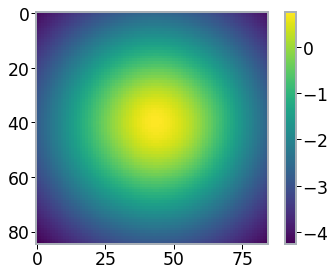

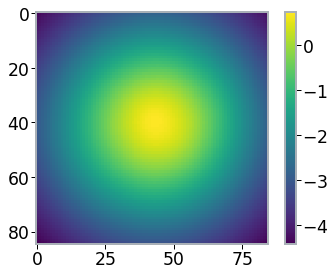

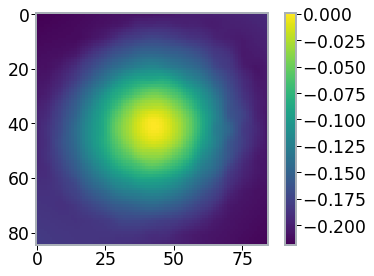


Max diff: 0.21848561218
Diff sum: 1107.1898411


In [153]:
def potential_indef(x, y, x2=None, y2=None):
    """
    Indefinite integral for a lensing potential

    Args:
        x, y <float/np.ndarray> - theta coordinate components

    Kwargs:
        x2, y2 <float/np.ndarray> - optionally the squared arguments can be passed
                                    to increase efficiency
    """
    if x2 is None:
        x2 = x*x
    if y2 is None:
        y2 = y*y
    return x*y*(np.log(x2+y2) - 3) + x2*np.arctan(y/x) + y2*np.arctan(x/y)


def potential(x, y, xn, yn, a):
    """
    Potential contribution of the n-th pixel

    Args:
        x, y <float/np.ndarray> - theta coordinate components of the potential
        xn, yn <float/np.ndarray> - pixel coordinates of the kappa grid
        a <float> - pixel scale of the kappa grid
    """
    xm, xp = x-xn-0.5*a, x-xn+0.5*a
    ym, yp = y-yn-0.5*a, y-yn+0.5*a
    xm2, xp2 = xm*xm, xp*xp
    ym2, yp2 = ym*ym, yp*yp
    return potential_indef(xm, ym, xm2, ym2) + potential_indef(xp, yp, xp2, yp2) \
        - potential_indef(xm, yp, xm2, yp2) - potential_indef(xp, ym, xp2, ym2)


def potential_grid(kappa, N, grid_size, verbose=False):
    """
    The entire potential grid

    Args:
        kappa <np.ndarray> - the kappa grid
        pixel_size <float> - pixel scale of the kappa grid
        N <int> - number of grid points along the axes of the potential grid
        grid_size <float> - the length of the grid along the axes of the kappa grid

    Kwargs:
        verbose <bool> - verbose mode; print command line statements

    Return:
        gx, gy, psi <np.ndarray> - the x and y grid coordinates and the potential grid
    """
    N += (N % 2 == 0) and 1
    x = np.linspace(-grid_size/2., grid_size/2., N)
    y = np.linspace(-grid_size/2., grid_size/2., N)
    xkappa = np.linspace(-grid_size/2., grid_size/2., kappa.shape[0])
    ykappa = np.linspace(-grid_size/2., grid_size/2., kappa.shape[1])
    pixel_size = abs(xkappa[0] - xkappa[1])

    gx, gy = np.meshgrid(x, y)

    if verbose:
        print("kappa:     \t{}".format(kappa.shape))
        print("pixel_size:\t{}".format(pixel_size))
        print("N:         \t{}".format(N))
        print("grid_size: \t{}".format(grid_size))

    psi = np.zeros((N, N))
    for m, ym in enumerate(ykappa):
        for n, xn in enumerate(xkappa):
            psi += kappa[m, n]*potential(gx, gy, xn, ym, pixel_size)
    psi *= -1./(2*np.pi)

    return gx, gy, psi


obj, data = glass_state.models[minidx]['obj,data'][0]
subdiv = 1
pixel_size = obj.basis.top_level_cell_size / subdiv
maplen = 2 * obj.basis.maprad
# maplen = 2 * obj.basis.maprad + pixel_size/2
kmap = obj.basis._to_grid(data['kappa'], subdiv)
gx, gy, pot = potential_grid(kmap, pixel_size, 85, maplen, verbose=1)
plt.imshow(pot)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

pot_gls = obj.basis.potential_grid(data)
plt.imshow(pot_gls)
plt.colorbar()
plt.show()

diff = pot_gls - pot
plt.imshow(diff)
plt.colorbar()
plt.show()
print("\nMax diff: {}".format(np.max(np.abs(diff))))
print("Diff sum: {}".format(np.sum(np.abs(diff))))


Arrival time surface is

\begin{equation}
\tau(\mathbf{\theta}) = \frac{1}{2} \theta^{2} - \psi(\mathbf{\theta}) + \mathbf{\theta}\cdot\mathbf{\beta} + \frac{1}{2} \beta^{2}
\end{equation}

The mass-sheet degeneracy only affects the first two terms. We want to make use of this degeneracy to find the best fitting GLASS model to the EAGLE model.

\begin{equation}
\tau(\mathbf{\theta})_{\text{deg}} = \frac{1}{2} \theta^{2} - \psi(\mathbf{\theta})
\end{equation}

In other words we search for

\begin{equation}
\min_{\text{models,} \lambda} 
\end{equation}


In [ ]:
def degarriv_grid(*args, **kwargs):
    """
    The degenerate arrival time surface without source shift: 1/2 theta^2 - psi

    Args:
        kappa <np.ndarray> - the kappa grid
        pixel_size <float> - pixel scale of the kappa grid
        N <int> - number of grid points along the axes of the potential grid
        grid_size <float> - the length of the grid along the axes of the kappa grid

    Kwargs:
        verbose <bool> - verbose mode; print command line statements

    Return:
        gx, gy, psi <np.ndarray> - the x and y grid coordinates and the potential grid
    """
    gx, gy, psi = potential_grid(*args, **kwargs)
    return gx, gy, 0.5*(gx*gx + gy*gy) + psi


def arriv_product(eagle_map, glass_map):
    """
    The inner product of the degenerate arrival time surfaces of a glass and eagle model

    Args:
        eagle_map <np.ndarray> - the arrival map of the eagle model
        glass_map <np.ndarray> - the arrival map of the glass model

    Kwargs:
        None

    Return:
        None
    """
    # eagle_map *= np.sum(glass_map)/np.sum(eagle_map)
    # return np.sum(eagle_map * glass_map) / np.sqrt(np.sum(glass_map*glass_map))
    return np.sum(eagle_map * glass_map) / np.linalg.norm(glass_map) / np.linalg.norm(eagle_map)


obj, data = glass_state.models[minidx]['obj,data'][0]
subdiv = 1
pixel_size = obj.basis.top_level_cell_size / subdiv
maplen = 2 * obj.basis.maprad
kmap = obj.basis._to_grid(data['kappa'], subdiv)
gx, gy, degarr = degarriv_grid(kmap, pixel_size, 85, maplen, verbose=1)
plt.contourf(gx, gy, degarr, levels=np.linspace(degarr.min(), degarr.max(), 14))
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()




### Arrival time loop for a single model


In [ ]:
%%skip True
# EAGLE models
kid = "H3S0A0B90G0"  # "H10S0A0B90G0" "H36S0A0B90G0"
filepath = kappa_map_files[kid][0]
eagle_model = fits.getdata(filepath, header=True)  # kappa, hdr

# GLASS models
statefile = prefiltered_fsynth50_states[kid][0]
# statefile = synthf50_states[kid][0]
# statefile = filtered_states[kid][0]
# statefile = states[kid][0]
glass_state = glass.glcmds.loadstate(statefile)
glass_state.make_ensemble_average()


# testing for the first ensemble model
# obj, data = glass_state.models[0]['obj,data'][0]
# pixel_size = obj.basis.top_level_cell_size
# maprad = obj.basis.top_level_cell_size * (obj.basis.pixrad)
# maplen = 2 * maprad
# shape = (2*obj.basis.pixrad+1,)*2
# eagle_kappa_map = resample_eaglemodel(eagle_model, (-maprad, maprad, -maprad, maprad), shape)
# glass_kappa_map = obj.basis._to_grid(data['kappa'], 1)
# gx_glass, gy_glass, glass_degarr = degarriv_grid(glass_kappa_map, pixel_size, 35, maplen)
# gx_eagle, gy_eagle, eagle_degarr = degarriv_grid(eagle_kappa_map, pixel_size, 35, maplen)

# plt.contourf(gx_glass, gy_glass, glass_degarr, levels=np.linspace(glass_degarr.min(), glass_degarr.max(), 14))
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()

# plt.contourf(gx_eagle, gy_eagle, eagle_degarr, levels=np.linspace(eagle_degarr.min(), eagle_degarr.max(), 14))
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()

In [ ]:
# EAGLE models
kid = "H3S0A0B90G0"  # "H10S0A0B90G0" "H36S0A0B90G0"
filepath = kappa_map_files[kid][0]
eagle_model = fits.getdata(filepath, header=True)  # kappa, hdr

# GLASS models
# statefile = prefiltered_fsynth50_states[kid][0]
# statefile = synthf50_states[kid][0]
# statefile = filtered_states[kid][0]
statefile = states[kid][0]
glass_state = glass.glcmds.loadstate(statefile)
glass_state.make_ensemble_average()


def degarr_comparison(eagle_model, gls):
    """
    Degenerate arrival time surface comparison loop for a glass and eagle model

    Args:
        eagle_model <(np.ndarray, astropy.io.fits.header.Header object)> - EAGLE .fits read output
        gls <glass.environment.Environment object> - a GLASS state

    Kwargs:
        None

    Return:
        None
    """
    arriv_products = []

    obj, _ = gls.models[0]['obj,data'][0]
    pixel_size = obj.basis.top_level_cell_size
    maprad = obj.basis.top_level_cell_size * (obj.basis.pixrad)
    maplen = 2 * maprad
    shape = (2*obj.basis.pixrad+1,)*2
    eagle_kappa_map = resample_eaglemodel(eagle_model, (-maprad, maprad, -maprad, maprad), shape)
    for m in gls.models:
        obj, data = m['obj,data'][0]
        glass_kappa_map = obj.basis._to_grid(data['kappa'], 1)
    
        # get arrival maps
        gx_glass, gy_glass, glass_degarr = degarriv_grid(glass_kappa_map, pixel_size, 35, maplen)
        gx_eagle, gy_eagle, eagle_degarr = degarriv_grid(eagle_kappa_map, pixel_size, 35, maplen)

        p = arriv_product(eagle_degarr, glass_degarr)
        arriv_products.append(p)

    return arriv_products
    

inner_prods = degarr_comparison(eagle_model, glass_state)
plt.hist(inner_prods, bins=16)
plt.show()



Best fitting model index: 255
with inner product of 0.789789947737


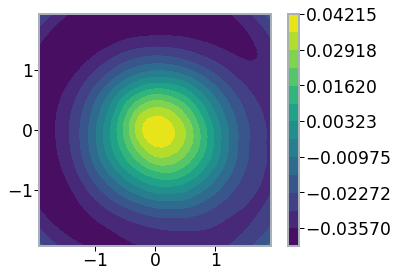

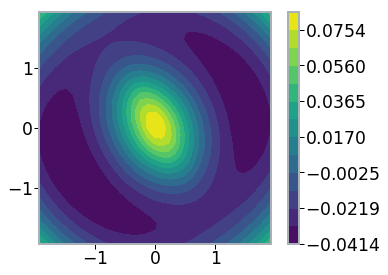

[[1.4500000000000002, 0.8500000000000001], [-1.4500000000000002, -0.35000000000000003], [-1.25, 1.0], [0.2, -1.55]]


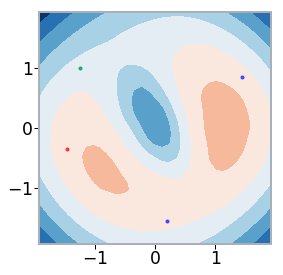

In [59]:
maxidx = np.argmax(inner_prods)
minidx3 = np.argmin(inner_prods)

print("Best fitting model index: {}".format(maxidx))
print("with inner product of {}".format(inner_prods[maxidx]))

obj, data = glass_state.models[maxidx]['obj,data'][0]
pixel_size = obj.basis.top_level_cell_size
maprad = obj.basis.top_level_cell_size * (obj.basis.pixrad)
maplen = 2 * maprad
shape = (2*obj.basis.pixrad+1,)*2
eagle_kappa_map = resample_eaglemodel(eagle_model, (-maprad, maprad, -maprad, maprad), shape)
glass_kappa_map = obj.basis._to_grid(data['kappa'], 1)
gx_glass, gy_glass, glass_degarr = degarriv_grid(glass_kappa_map, pixel_size, 35, maplen)
gx_eagle, gy_eagle, eagle_degarr = degarriv_grid(eagle_kappa_map, pixel_size, 35, maplen)
glass_degarr /= np.linalg.norm(glass_degarr)
eagle_degarr /= np.linalg.norm(eagle_degarr)

plt.contourf(gx_glass, gy_glass, glass_degarr, levels=np.linspace(glass_degarr.min(), glass_degarr.max(), 14))
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

plt.contourf(gx_eagle, gy_eagle, eagle_degarr, levels=np.linspace(eagle_degarr.min(), eagle_degarr.max(), 14))
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()


# obj, data = glass_state.models[minidx3]['obj,data'][0]
# pixel_size = obj.basis.top_level_cell_size
# maprad = obj.basis.top_level_cell_size * (obj.basis.pixrad)
# maplen = 2 * maprad
# shape = (2*obj.basis.pixrad+1,)*2
# eagle_kappa_map = resample_eaglemodel(eagle_model, (-maprad, maprad, -maprad, maprad), shape)
# glass_kappa_map = obj.basis._to_grid(data['kappa'], 1)
# gx_glass, gy_glass, glass_degarr = degarriv_grid(glass_kappa_map, pixel_size, 35, maplen)
# gx_eagle, gy_eagle, eagle_degarr = degarriv_grid(eagle_kappa_map, pixel_size, 35, maplen)
# glass_degarr /= np.linalg.norm(glass_degarr)
# eagle_degarr /= np.linalg.norm(eagle_degarr)

fig = plt.figure()
ax = fig.add_subplot(111)
diff = eagle_degarr-glass_degarr
# glass_state.img_plot(obj_index=0)
ax.contourf(gx_glass, gy_glass, diff, cmap='RdBu', vmin=-np.max(diff), vmax=np.max(diff))
# ax.add_colorbar()
imgs = [109.0, 97.0], [51.0, 73.0], [55.0, 100.0], [84.0, 49.0]
imgs = [[(x[0]-80)*0.05, (x[1]-80)*0.05] for x in imgs]
print(imgs)
for i in imgs:
    ax.plot(*i, marker='.')
plt.gca().set_aspect('equal')
plt.show()


# plt.contourf(gx_glass, gy_glass, glass_degarr, levels=np.linspace(glass_degarr.min(), glass_degarr.max(), 14))
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()

# plt.contourf(gx_eagle, gy_eagle, eagle_degarr, levels=np.linspace(eagle_degarr.min(), eagle_degarr.max(), 14))
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()


# plt.imshow(glass_kappa_map)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()

# plt.imshow(eagle_kappa_map)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.show()







### Arrival time loop for ALL 3 test cases (H3S0A0B90G0, H10S0A0B90G0, H36S0A0B90G0)

In [ ]:
%%skip True
for k in ["H3S0A0B90G0", "H10S0A0B90G0", "H36S0A0B90G0"]:
    filepath = kappa_map_files[k][0]
    eagle_model = fits.getdata(filepath, header=True)

    for idx in range(len(states[k])):
        statefile = states[k][idx]
        fltrdfile = filtered_states[k][idx]
        synthfile = fsynth50_states[k][idx]
        fltrdsynthfile = prefiltered_fsynth50_states[k][idx]

        f = fltrdsynthfile

        glass_state = glass.glcmds.loadstate(f)
        glass_state.make_ensemble_average()

        N_models = len(glass_state.models)
        maprad = glass_state.models[0]['obj,data'][0][0].basis.top_level_cell_size \
                 * glass_state.models[0]['obj,data'][0][0].basis.pixrad
        extent = (-maprad, maprad, -maprad, maprad)
        print("Number of models: {:4d}".format(N_models))
        print("Maprad: {:02.4f}".format(maprad))

        deltas = []
        for i, m in enumerate(glass_state.models):
            objdta = m['obj,data'][0]
            glass_kappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)

            eagle_kappa_resmap = resample_eaglemodel(eagle_model, extent, glass_kappa_map.shape)

            delta_map = eagle_kappa_resmap - glass_kappa_map
            delta2_map = resid_map * resid_map
            deltas.append(np.sum(delta2_map))

        minidx = np.argmin(deltas)
        print("Closest model: Index {} with a delta^2 of {}".format(minidx, residuals[minidx]))
        objdta = glass_state.models[minidx]['obj,data'][0]
        glass_kappa_map = objdta[0].basis._to_grid(objdta[1]['kappa'], 1)
        eagle_kappa_resmap = resample_eaglemodel(eagle_model, extent, glass_kappa_map.shape)